# Pipeline Using DBSCAN Clustering

### Step 1: Select a Scenario + Get Images

In [4]:
!pip install open3d

In [ ]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
import open3d as o3d
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import pdb
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN



In [ ]:

depth_np = np.load('./depth_translation_glasses.npy')
colour_np = np.load('./colour_translated_glasses.npy')

# # Translation glasses
colour_img1 = colour_np[19]
colour_img2 = colour_np[249]
depth_img1 = depth_np[19]
depth_img2 = depth_np[249]

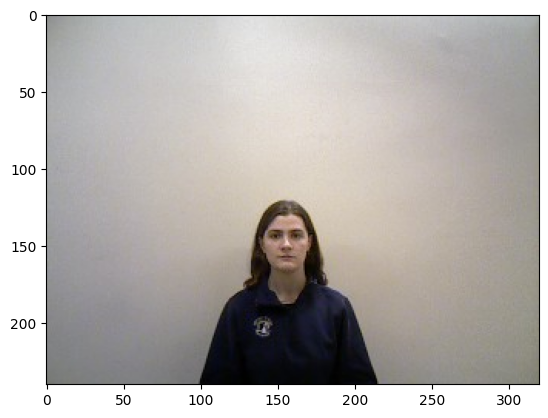

In [25]:
plt.imshow(colour_img1)

### Step 2: Get Keypoints + Corresponding Features

In [26]:
def getORBFeatures(depth_img1, depth_img2):

    # Normalize depth images to the range [0, 255] and convert to uint8
    depth_img1 = cv2.normalize(depth_img1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_img2 = cv2.normalize(depth_img2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Initialize the ORB detector
    orb = cv2.ORB_create(nfeatures=250)  # You can adjust `nfeatures` for more/less keypoints

    # Detect keypoints and compute descriptors for both images
    keypoints1, features1 = orb.detectAndCompute(depth_img1, None)
    keypoints2, features2 = orb.detectAndCompute(depth_img2, None)

    print("Features1 shape:", features1.shape if features1 is not None else "None")
    print("Features2 shape:", features2.shape if features2 is not None else "None")

    # Use BFMatcher with Hamming distance (default for ORB)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Perform feature matching
    matches = bf.match(features1, features2)

    # Sort matches by distance (lower distance is better)
    good_matches = sorted(matches, key=lambda x: x.distance)

    # Draw the good matches on the images
    img_matches = cv2.drawMatches(depth_img1, keypoints1, depth_img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Show the result
    plt.figure(figsize=(10, 5))
    plt.imshow(img_matches)
    plt.title("ORB Feature Matching")
    plt.axis("off")
    plt.show()

    return good_matches, keypoints1, keypoints2, features1, features2


Features1 shape: (58, 32)
Features2 shape: (53, 32)


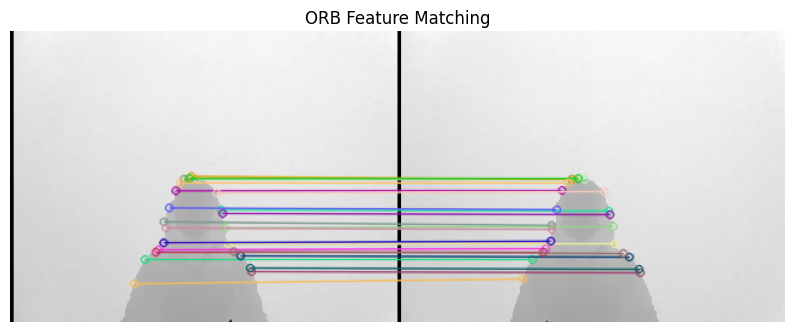

In [27]:
good_matches, keypoints1, keypoints2, features1, features2= getORBFeatures(depth_img1, depth_img2)

In [28]:
distances = []
for i, match in enumerate(good_matches):
    print(f'Good Match {i+1}: QueryIdx = {match.queryIdx}, TrainIdx = {match.trainIdx}, Distance = {match.distance}')
    distances.append(match.distance)

mse = np.mean(distances)
print(mse)
good_keypoints1 = [keypoints1[m.queryIdx] for m in good_matches]
good_keypoints2 = [keypoints2[m.trainIdx] for m in good_matches]


Good Match 1: QueryIdx = 56, TrainIdx = 51, Distance = 4.0
Good Match 2: QueryIdx = 57, TrainIdx = 52, Distance = 8.0
Good Match 3: QueryIdx = 23, TrainIdx = 16, Distance = 14.0
Good Match 4: QueryIdx = 55, TrainIdx = 48, Distance = 18.0
Good Match 5: QueryIdx = 7, TrainIdx = 5, Distance = 20.0
Good Match 6: QueryIdx = 28, TrainIdx = 23, Distance = 20.0
Good Match 7: QueryIdx = 36, TrainIdx = 6, Distance = 20.0
Good Match 8: QueryIdx = 50, TrainIdx = 38, Distance = 20.0
Good Match 9: QueryIdx = 31, TrainIdx = 26, Distance = 21.0
Good Match 10: QueryIdx = 29, TrainIdx = 24, Distance = 22.0
Good Match 11: QueryIdx = 21, TrainIdx = 15, Distance = 26.0
Good Match 12: QueryIdx = 39, TrainIdx = 9, Distance = 28.0
Good Match 13: QueryIdx = 15, TrainIdx = 11, Distance = 32.0
Good Match 14: QueryIdx = 46, TrainIdx = 42, Distance = 32.0
Good Match 15: QueryIdx = 17, TrainIdx = 12, Distance = 33.0
Good Match 16: QueryIdx = 25, TrainIdx = 21, Distance = 33.0
Good Match 17: QueryIdx = 45, TrainIdx 

### Step 3: Compute Transformation btwn Images

In [29]:
kps1 = []
kps2 = []
kps1 = np.array([kp.pt for kp in good_keypoints1])
kps2 = np.array([kp.pt for kp in good_keypoints2])


In [30]:
affineTransform2D = cv2.estimateAffine2D(kps1, kps2, method=cv2.RANSAC)

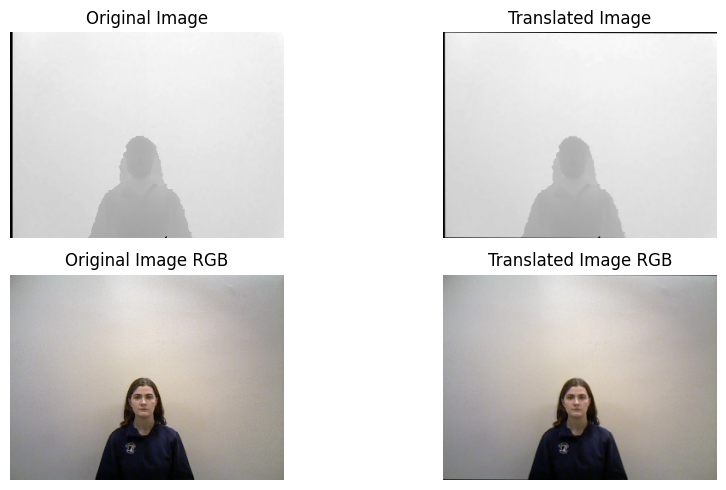

In [31]:
#transformed_points = cv2.transform(np.array([kps1]), affineTransform[0])
height, width = depth_img1.shape

# Apply the affine transformation to the image using warpAffine
translated_img_depth = cv2.warpAffine(depth_img1, affineTransform2D[0], (width, height))
translated_img_colour = cv2.warpAffine(colour_img1, affineTransform2D[0], (width, height))

# Display the original and the transformed image side by side
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(2, 2, 1)
plt.imshow(depth_img1, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Plot the transformed image
plt.subplot(2, 2, 2)
plt.imshow(translated_img_depth, cmap='gray')
plt.title("Translated Image")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(colour_img1)
plt.title("Original Image RGB")
plt.axis('off')

# Plot the transformed image
plt.subplot(2, 2, 4)
plt.imshow(translated_img_colour)
plt.title("Translated Image RGB")
plt.axis('off')
plt.tight_layout()
plt.show()

#### Visualize Transformation

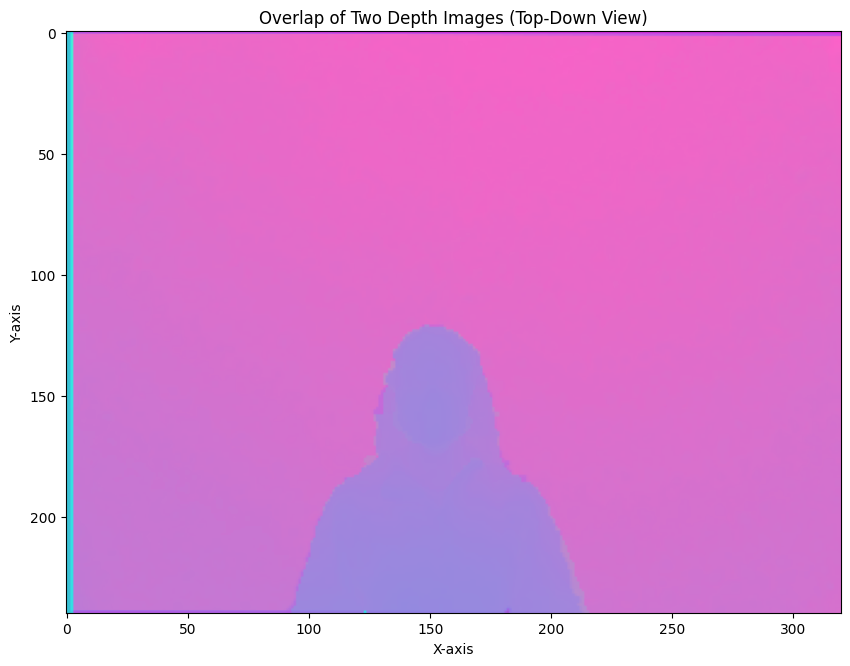

In [32]:
# Generate X, Y coordinates for the depth maps
x = np.arange(translated_img_depth.shape[1])
y = np.arange(translated_img_depth.shape[0])
x, y = np.meshgrid(x, y)

plt.figure(figsize=(10, 8))

# Plot the first depth image
plt.imshow(translated_img_depth, cmap='viridis', alpha=0.6, label="Depth Image 1")

# Overlay the second depth image
plt.imshow(depth_img2, cmap='cool', alpha=0.6, label="Depth Image 2")


# plt.imshow(translated_img_colour, alpha=0.6, label="Depth Image 1")

# # Overlay the second depth image
# plt.imshow(colour_img2, alpha=0.6, label="Depth Image 2")

# Add a colorbar

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Overlap of Two Depth Images (Top-Down View)")

plt.show()


### Step 4: DBSCAN Clustering on Occluded Image

#### Get the Saturation Channel from the Original Occluded Image

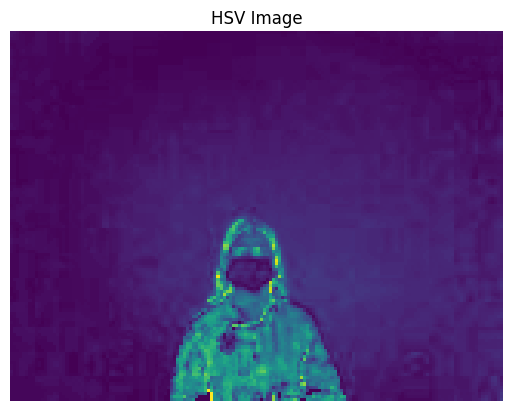

In [45]:
small_colour_img2 = cv2.resize(colour_img2, (160, 120))  # Smaller image size for dbscan memory requirements

hsvimg2 = cv2.cvtColor(small_colour_img2, cv2.COLOR_RGB2HSV)
hsvimg2 = hsvimg2[:,:,1]
plt.title('HSV Image')
plt.axis('off')
plt.imshow(hsvimg2)

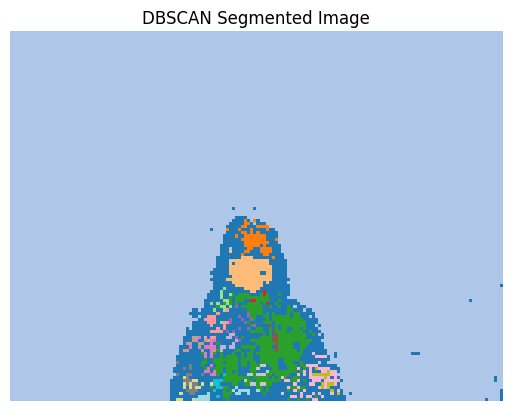

In [46]:
# Clustering on colour AND position

height, width = hsvimg2.shape[:2]

y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
positions = np.stack([x.ravel(), y.ravel()], axis=-1)  # (n_pixels, 2) - x and y coordinates

saturation = hsvimg2.ravel()  # Flatten the Saturation channel (1D array)

features = np.vstack([positions.T, saturation]).T  # Shape (n_pixels, 3)

# Apply DBSCAN, these parameters might need to be adjusted!! depends on dataset
# need to find params that give best mask segmentation given lighting, clothing etc.
dbscan = DBSCAN(eps=5, min_samples=10)  # Mask
# dbscan = DBSCAN(eps=4, min_samples=10)    # scarf
# dbscan = DBSCAN(eps=8, min_samples=10) # sunglasses params
# dbscan = DBSCAN(eps=8, min_samples=5) # sunglasses params
# dbscan = DBSCAN(eps=8, min_samples=15) # sunglasses params hair down
# dbscan = DBSCAN(eps=6, min_samples=9) # sunglasses params hair down
labels = dbscan.fit_predict(features)

# Reshape the labels
segmented_image = labels.reshape(hsvimg2.shape[:2])

# Visualize
plt.imshow(segmented_image, cmap='tab20')
plt.title("DBSCAN Segmented Image")
plt.axis('off')
plt.show()

In [47]:
print('number of clusters: ', np.unique(labels).shape)

number of clusters:  (21,)


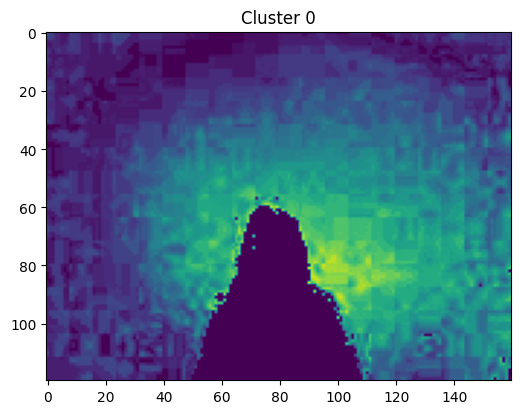

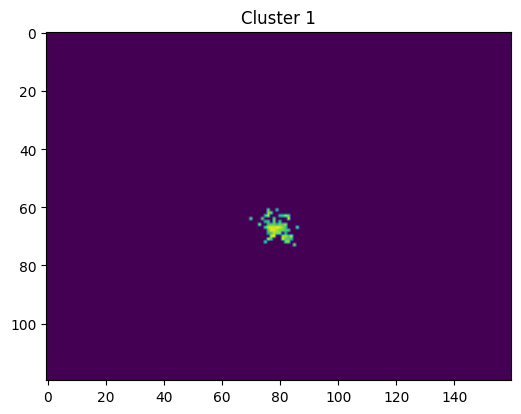

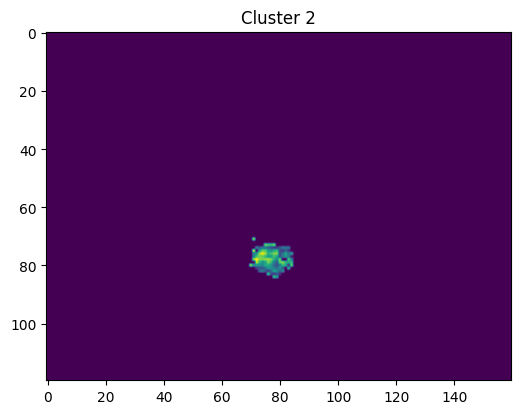

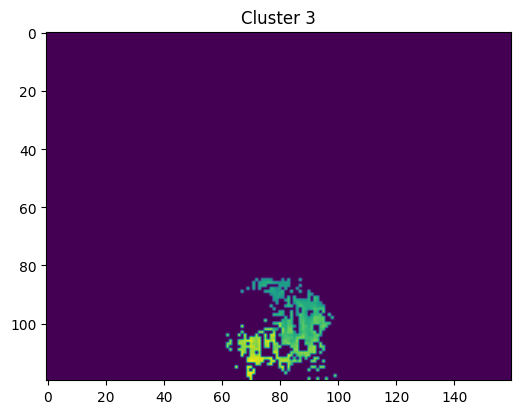

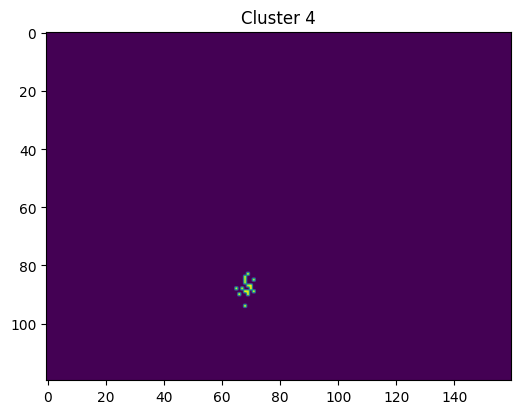

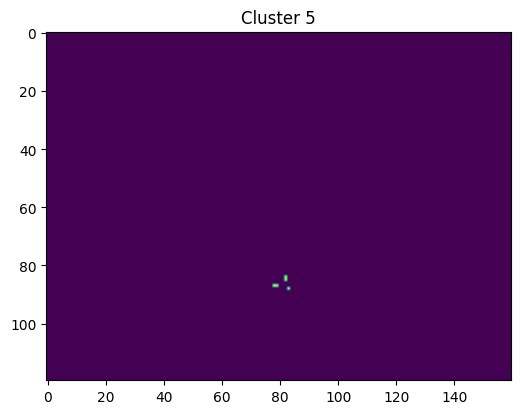

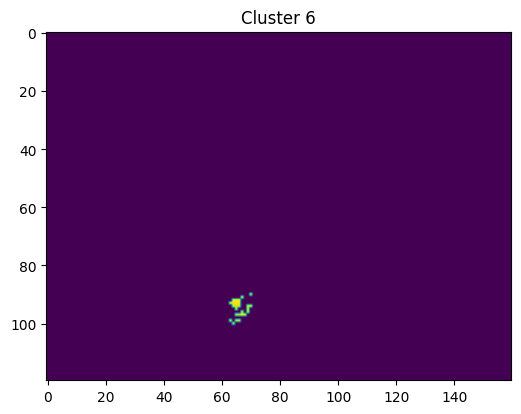

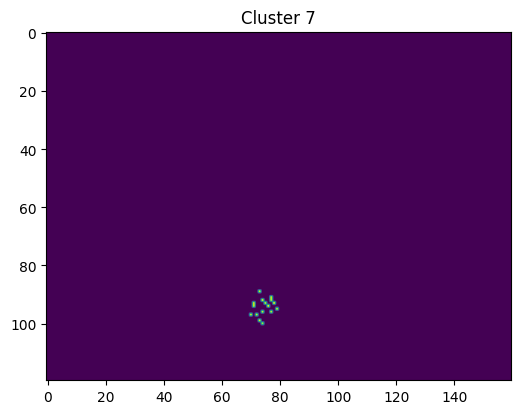

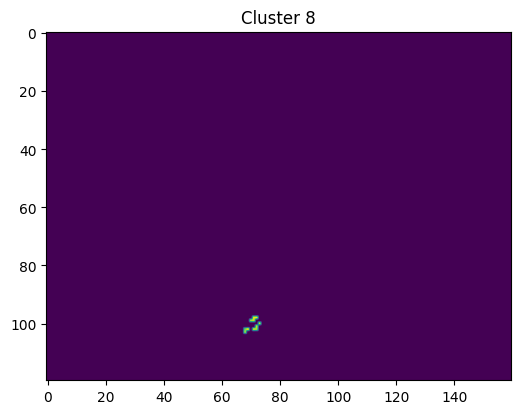

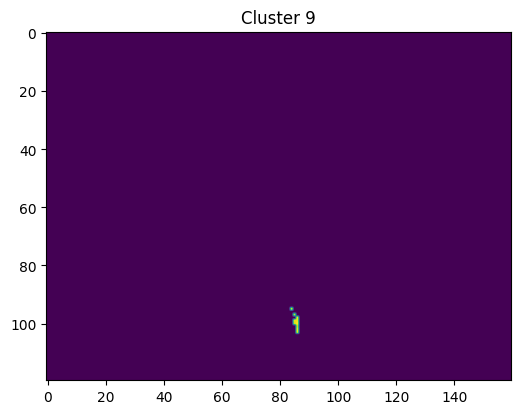

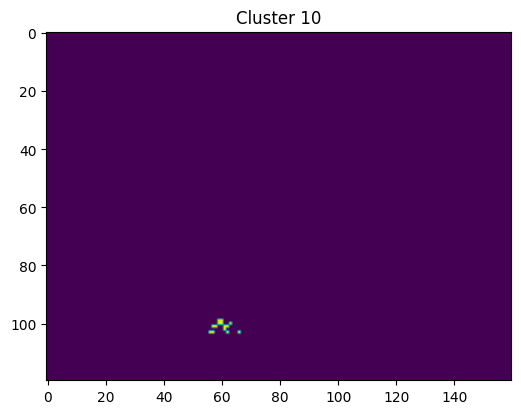

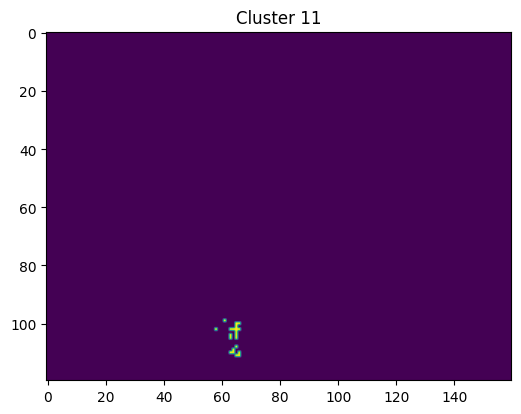

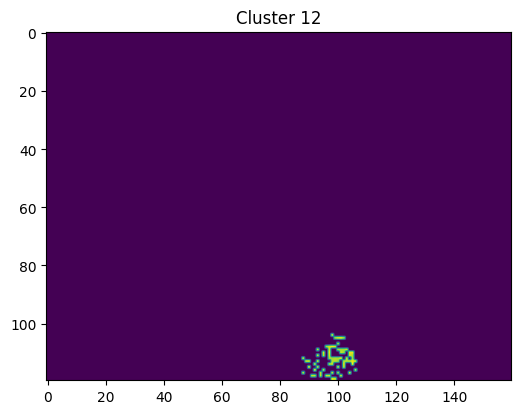

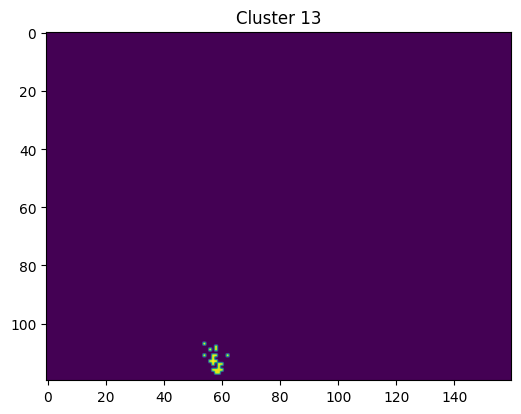

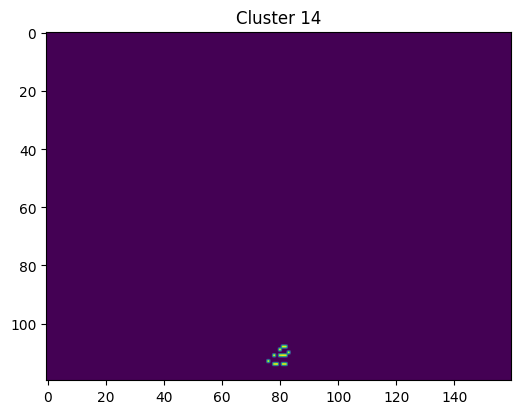

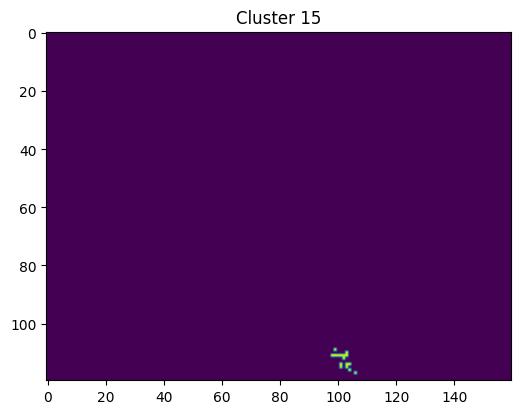

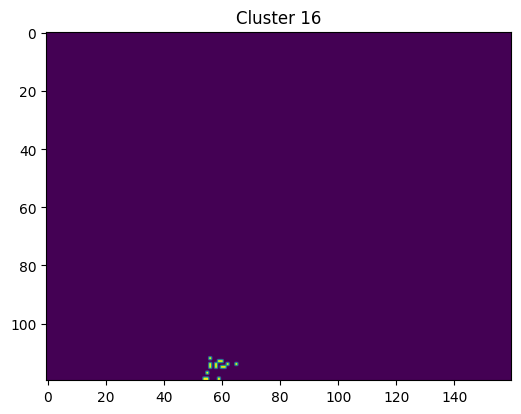

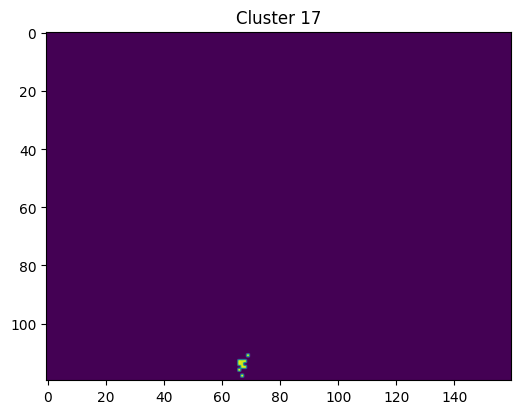

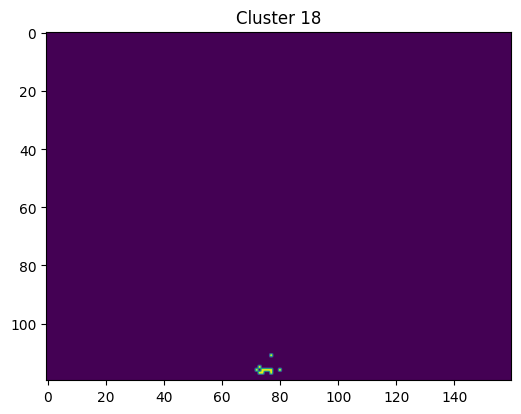

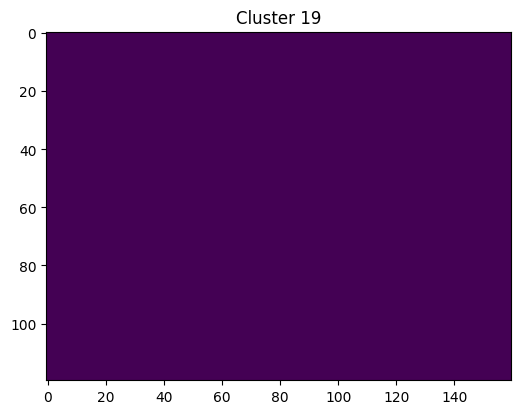

In [48]:
# # plot all clusters
unique_labels = np.unique(labels)
unique_labels = unique_labels[unique_labels != -1]  # Exclude noise label (-1)

# # Iterate through each unique label and create a mask for each cluster
for label in unique_labels:
    mask = segmented_image == label
    cluster_image = np.zeros_like(hsvimg2)
    cluster_image[mask] = hsvimg2[mask]
    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_image)
    plt.title(f"Cluster {label}")
    plt.show()

In [49]:
# # grab the cluster corresponding to the mask (MANUALLY CHOOSING) in case face detection doesn't work

# cluster_label = unique_labels[1]
# mask = (segmented_image == cluster_label)

# # cluster_label_1 = unique_labels[2]
# # cluster_label_2 = unique_labels[8]
# # mask = (segmented_image == cluster_label_1) | (segmented_image == cluster_label_2)

# # resize since we shrunk it down before
# mask_resized = cv2.resize(mask.astype(np.uint8), (original_width, original_height), interpolation=cv2.INTER_NEAREST)

# cluster_overlay = np.zeros_like(colour_img)

# # Retain the parts of the original image corresponding to the fourth cluster
# cluster_overlay[mask_resized == 1] = colour_img[mask_resized == 1]
# yellow_overlay = np.zeros_like(colour_img)
# yellow_overlay[mask_resized == 1] = [255, 255, 0]
# # Visualize
# plt.figure(figsize=(8, 6))
# plt.imshow(colour_img)
# plt.imshow(yellow_overlay, alpha=0.6)  # Overlay the cluster with some transparency
# plt.title(f"Cluster Overlay on Original Image")
# plt.axis('off')
# plt.figure(figsize=(8, 6))
# plt.imshow(mask)
# plt.axis('off')
# plt.show()

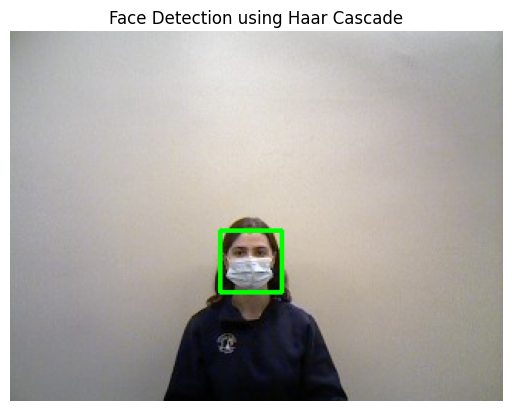

In [50]:
# Face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# do face detection on a 1 channel gray image
gray_image = cv2.cvtColor(colour_img2, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

face_box_colour_img = colour_img2.copy() # create a copy with face outlined in box
for (x, y, w, h) in faces:
    cv2.rectangle(face_box_colour_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# show face detection on original image
plt.imshow(face_box_colour_img)
plt.axis('off')
plt.title("Face Detection using Haar Cascade")
plt.show()

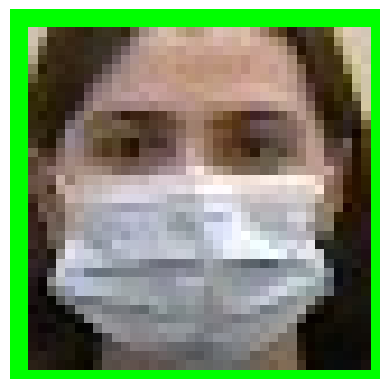

In [67]:
# face_region = cv2.GaussianBlur(face_region, (5,5), 0)
face_region = face_box_colour_img[y:y+h, x:x+w]
plt.axis('off')
plt.imshow(face_region)

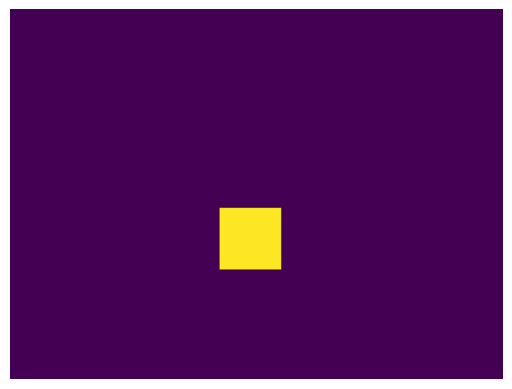

In [68]:
# create binary mask (1 channel so using gray image)
face_binary_mask = np.zeros_like(gray_image, dtype=np.uint8)
face_binary_mask[y:y+h, x:x+w] = 1
plt.axis('off')
plt.imshow(face_binary_mask)

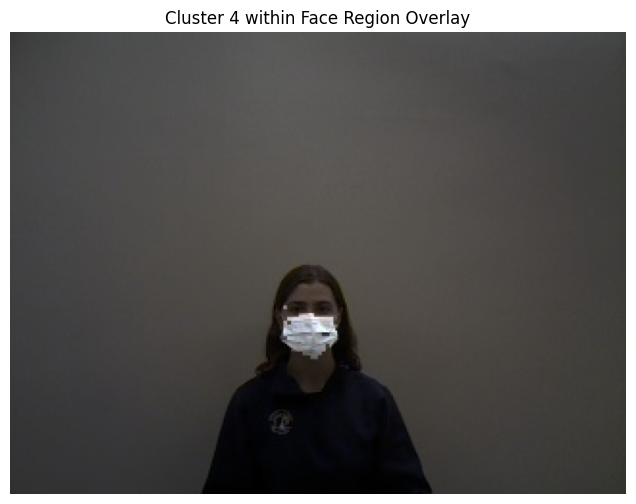

In [53]:
best_cluster_label = None
max_overlap = 0

for cluster_label in unique_labels:
    cluster_mask = (segmented_image == cluster_label)
    # Resize the mask to match the original image size (240, 320)
    cluster_mask_resized = cv2.resize(cluster_mask.astype(np.uint8), (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # overlap between the cluster and face region (intersection of both masks), pixel wise
    overlap = np.sum(cluster_mask_resized * face_binary_mask)

    if overlap > max_overlap:
        max_overlap = overlap
        best_cluster_label = cluster_label

# get the best cluster and resize it to image dimensions
best_cluster_mask = (segmented_image == best_cluster_label)
best_cluster_mask_resized = cv2.resize(best_cluster_mask.astype(np.uint8), (original_width, original_height), interpolation=cv2.INTER_NEAREST)

# Create the overlay image, set pixels where cluster exists to pixels from colour_img (bright)
cluster_overlay = np.zeros_like(colour_img2)
cluster_overlay[best_cluster_mask_resized == 1] = colour_img2[best_cluster_mask_resized == 1]

# Visualize the cluster overlay
plt.figure(figsize=(8, 6))
plt.imshow(colour_img2)
# Overlay the selected cluster with some transparency, black mask with white pixels where mask is
plt.imshow(cluster_overlay, alpha=0.6)
plt.title(f"Cluster " + str(4) + " within Face Region Overlay")
plt.axis('off')
plt.show()


In [54]:
print('Best cluster based on overlap with face region: ', best_cluster_label)

Best cluster based on overlap with face region:  2


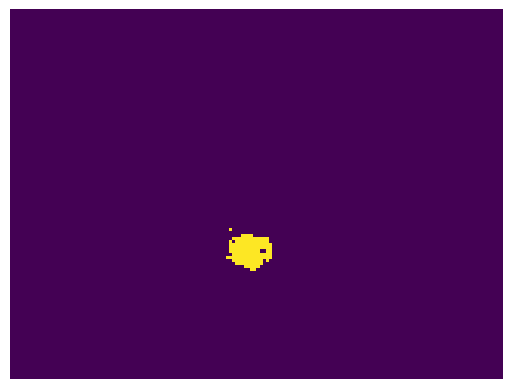

In [69]:
plt.axis('off')
plt.imshow(best_cluster_mask)

In [59]:
# np.save('dbscan_mask.npy', best_cluster_mask)
best_cluster_mask_uint8 = np.uint8(best_cluster_mask * 255)

best_cluster_mask_resized = cv2.resize(best_cluster_mask_uint8, (320, 240))
binary_mask = (best_cluster_mask_resized > 0) # now convert back to binary

#### Aside: DBSCAN on JUST the face region. Isn't helpful because we get another bunch of clusters and still have to determine which is the face mask




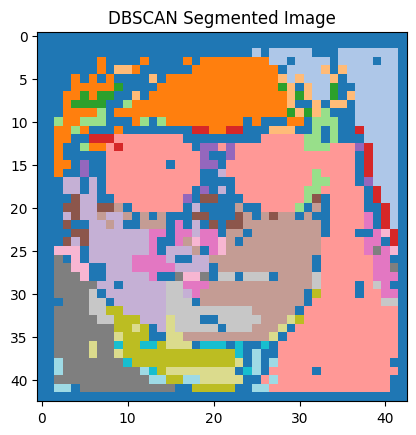

In [ ]:
height, width = face_region.shape[:2]

y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
positions = np.stack([x.ravel(), y.ravel()], axis=-1)  # (n_pixels, 2) - x and y coordinates

# flatten the face region into a 2D array of pixel color values
colors = face_region.reshape(-1, 3)  # (n_pixels, 3) - color channels (R, G, B)

features = np.hstack([positions, colors])

dbscan = DBSCAN(eps=6, min_samples=2)  # manually tuned
labels = dbscan.fit_predict(features)

segmented_image = labels.reshape(height, width)

# Visualize the segmented image
plt.imshow(segmented_image, cmap='tab20')
plt.title("DBSCAN Segmented Image")
plt.show()

### Step 5: Project Mask Onto Occluded Image

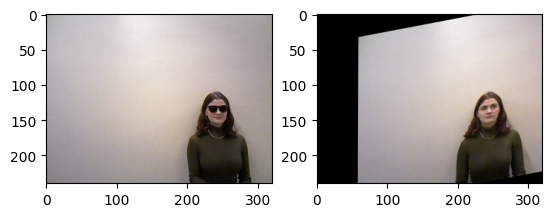

In [ ]:
plt.subplot(1,2,1)
plt.imshow(colour_img2)
plt.subplot(1,2,2)
plt.imshow(translated_img_colour)


Project the digital mask onto the Image2 to see that we're actually getting the mask

(-0.5, 319.5, 239.5, -0.5)

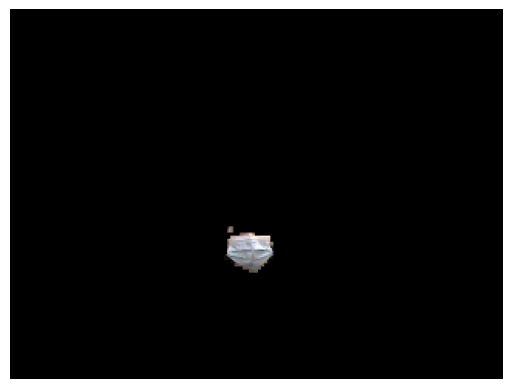

In [63]:
rbg_nonoccluded = np.array(colour_img2) # col_image1 is the NON-OCCLUDED original image
rbg_nonoccluded[binary_mask == 0] = 0
plt.imshow(rbg_nonoccluded)
plt.axis('off')

(-0.5, 319.5, 239.5, -0.5)

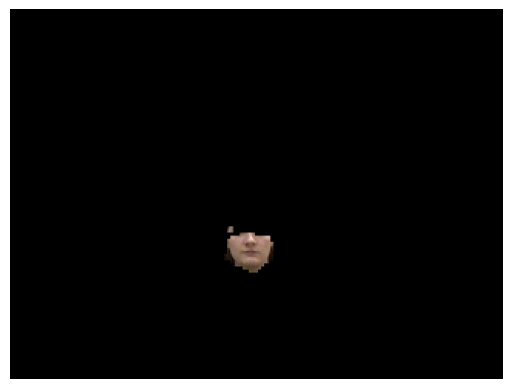

In [65]:
rbg_nonoccluded = np.array(translated_img_colour) # col_image1 is the NON-OCCLUDED original image
rbg_nonoccluded[binary_mask == 0] = 0
plt.imshow(rbg_nonoccluded)
plt.axis('off')



Plot the mask onto the OCCLUDED image

(-0.5, 319.5, 239.5, -0.5)

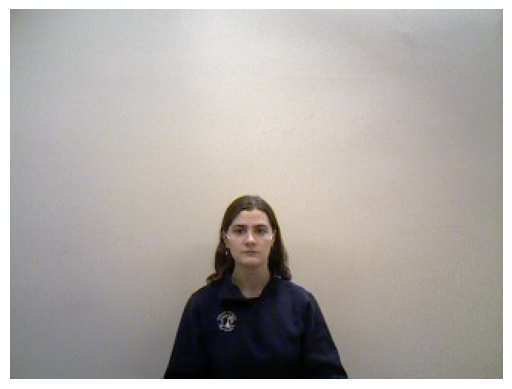

In [66]:
# place the above region on the occluded image

face_seg = rbg_nonoccluded
mask = np.any(face_seg > 0, axis=-1)
# rbg_mask = np.array(col_image2) # col_image3 is the occluded image!!

rbg_mask = np.array(colour_img2) # col_image3 is the occluded image!!

rbg_mask[mask] = face_seg[mask] #

plt.imshow(rbg_mask)
plt.axis('off')

# plt.imshow(col_imag e2)